In [1]:
from __future__ import division
from IO import *
from cycler import cycler
import matplotlib as mpl
%matplotlib inline
from numba import autojit

%load_ext autoreload
%autoreload 2

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000_PhD/figures/"+todayStr+"/")
CSV_DIR_TODAY = os.path.expanduser("~/Dropbox/0000_PhD/csv/"+todayStr+"/")
CSV_DIR = os.path.expanduser("~/Dropbox/0000_PhD/csv/")
FIG_DIR = os.path.expanduser("~/Dropbox/0000_PhD/figures/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
    
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Instantiate classes
cortex = Cortex()
trn = TRN()
gr = GRAPH(cortex)

In [4]:
# #-------------------------------
# # PARAMS SEARCH
# #-------------------------------
c = cortex
c.N = 100
c.g = 10
c.d1 = 10
c.d2 = 30000
c.d3 = 10
c.initTime()
c.sigma = 60
c.WII = 1400 #2800
c.S = 100
c.model = "gp-izh-subnetworks"
c.glob = 0
c.plast = 1

# shared weights
c.sG = 10
c.sWII = 10

c.FACT = 1
c.r=0

c.ratio = 15
c.LTD  = 1e-0*4.7e-6 * c.FACT * c.N
c.LTP = c.ratio * c.LTD
c.dt = 0.25
c.tauv=15

c.with_currents = True

sWIIList = [0,10]
sGList = [0,1,5,10,15,20,25]
sGList = np.arange(0,25,4)
LTDList = [1e-9*4.7e-6 * c.FACT * c.N, 1e-0*4.7e-6 * c.FACT * c.N]
taulist = np.arange(11,95,4)


-1   1

-2   2

## READ CSV DATA

In [48]:
# df = pd.read_csv('/Users/GP1514/Dropbox/0000 - PhD/figures/20160628/' + 'df-plast-ok2.csv')
columns = ['tauv', 'd2','sWII', 'sG', 'LTD',
                             'maxBegin', 'argmaxBegin', 'maxEnd', 'argmaxEnd',
                            'f1Begin', 'p1Begin', 'f2Begin', 'p2Begin', 
                             'f1End', 'p1End', 'f2End', 'p2End', 
                             'fBothBegin', 'pBothBegin', 'fBothEnd', 'pBothEnd',
                               'gn1_', 'gn2_', 'gnshared_',
                                'gn1', 'gn2', 'gnshared',
           'key']
# df = pd.read_csv(CSV_DIR + 'with_plast-ok-t30-N100.csv', names=columns)
day = 20160701
sWII = 10
df = pd.read_csv('%s%s/with_plast-ok-t30-N100.csv' % (CSV_DIR, day), names=columns)
day = 20160705
df = pd.read_csv('%s%s/with_plast-T30-N400.csv' % (CSV_DIR, day), names=columns)


df.head()

,tauv,d2,sWII,sG,LTD,maxBegin,argmaxBegin,maxEnd,argmaxEnd,f1Begin,...,pBothBegin,fBothEnd,pBothEnd,gn1_,gn2_,gnshared_,gn1,gn2,gnshared,key
0,57,30000,0,0,0,13.877,8,28.012,9,41.958,...,26.855,31.968,28.407,0.014084,0.014164,NaN,0.014084,0.014164,NaN,-2
1,17,30000,0,0,0,59.869,11,32.082,11,45.954,...,30.038,43.956,28.759,0.014073,0.014108,NaN,0.014073,0.014108,NaN,-2
2,37,30000,0,0,0,40.548,9,33.715,9,45.954,...,27.577,33.966,27.059,0.014058,0.014007,NaN,0.014058,0.014007,NaN,-2
3,15,30000,0,0,0,31.803,12,31.046,11,45.954,...,26.196,47.952,17.869,0.014062,0.014098,NaN,0.014062,0.014098,NaN,-2
4,23,30000,0,0,0,12.743,9,20.451,11,53.946,...,24.949,41.958,24.039,0.014169,0.013970,NaN,0.014169,0.013970,NaN,-2


In [49]:
N = c.N
df = df[(df['tauv']>13) & (df['sWII']==sWII) ]
dfplast = df[(df['LTD']==True)]
dfnoplast = df[(df['LTD']==False)]
dfplast.head()

,tauv,d2,sWII,sG,LTD,maxBegin,argmaxBegin,maxEnd,argmaxEnd,f1Begin,...,pBothBegin,fBothEnd,pBothEnd,gn1_,gn2_,gnshared_,gn1,gn2,gnshared,key
2400,27,30000,10,0,1,30.1120,11,35.754,10,41.958,...,20.057,43.956,24.600,0.013811,0.014124,NaN,0.013707,0.012621,NaN,-2
2401,39,30000,10,0,1,16.4960,9,21.749,9,45.954,...,28.265,35.964,26.014,0.014020,0.013932,NaN,0.014014,0.012778,NaN,-2
2402,41,30000,10,0,1,12.0910,12,13.216,10,43.956,...,25.397,35.964,27.239,0.014298,0.014153,NaN,0.013844,0.012751,NaN,-2
2403,93,30000,10,0,1,14.6680,7,8.252,8,43.956,...,25.302,25.974,25.471,0.013941,0.013979,NaN,0.014013,0.014834,NaN,-2
2404,77,30000,10,0,1,8.2582,7,13.492,8,43.956,...,27.459,27.972,24.573,0.014199,0.013972,NaN,0.013569,0.013829,NaN,-2


## GAMMA

(600,)
(40, 15)
(600,)
(40, 15)


/Users/GP1514/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


(600,)
(40, 15)
(600,)
(40, 15)


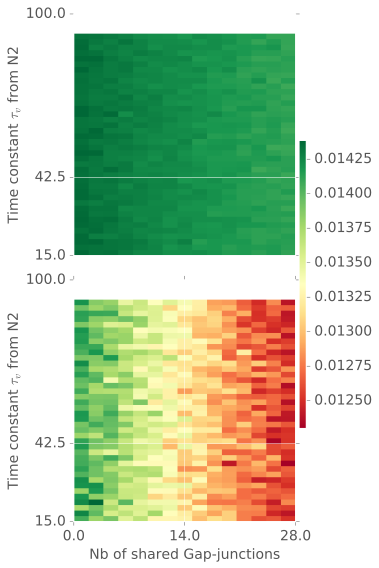

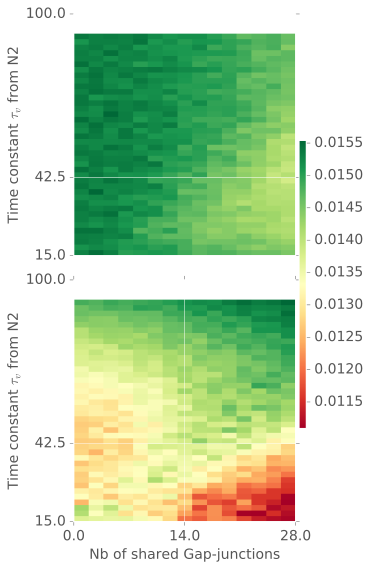

In [53]:
gr = GRAPH(cortex)
gr.plotGamma(dfnoplast, 'gn')
gr.plotGamma(dfplast, 'gn')

# Subnetwork Frequencies

(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)


0

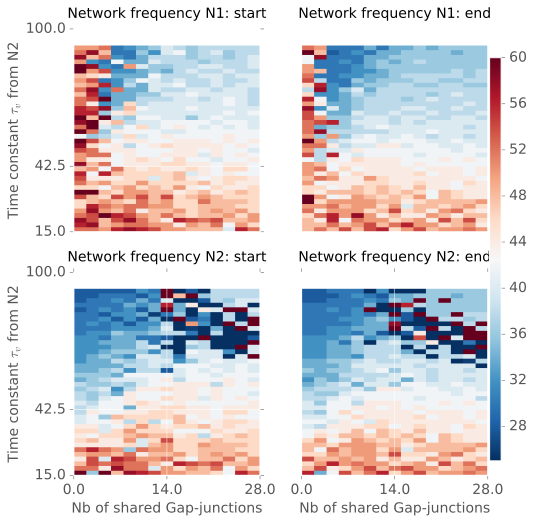

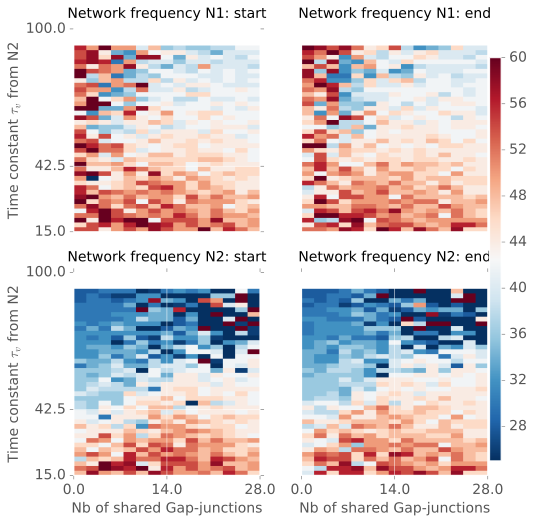

In [16]:
gr= GRAPH(cortex)
gr.plotEvolution(df, kind = 'frequency', LTD=True, vmin = 25, vmax=60)
gr.plotEvolution(df, kind = 'frequency', LTD=False, vmin = 25 ,vmax=60)

(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)


0

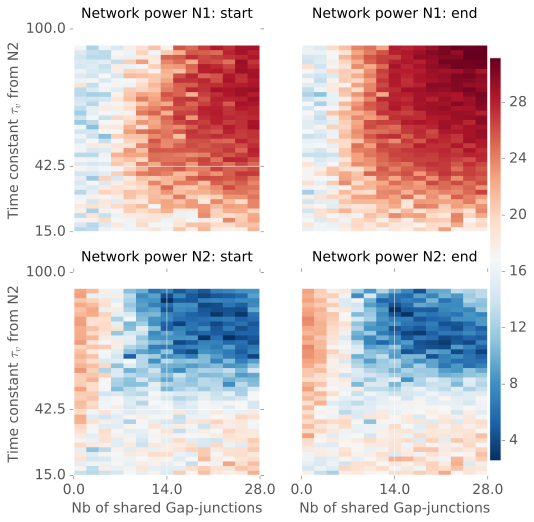

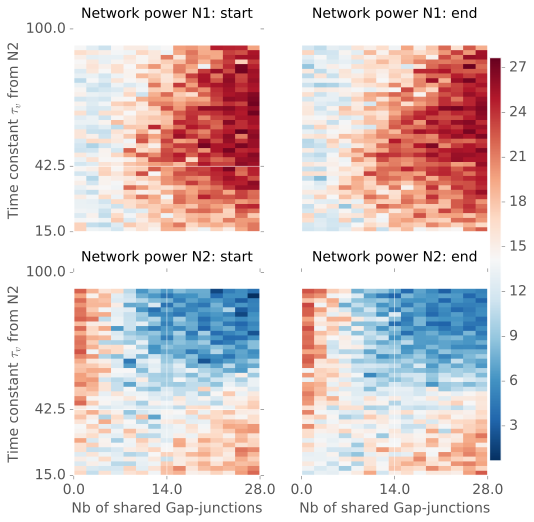

In [17]:
gr=GRAPH(cortex)
gr.plotEvolution(df, kind='power', LTD=True)
gr.plotEvolution(df, kind='power', LTD=False)

(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)


0

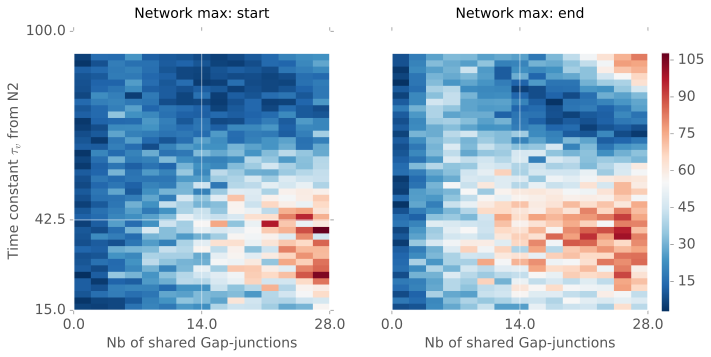

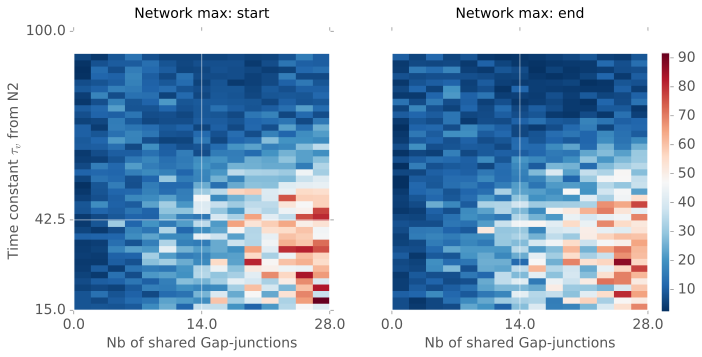

In [18]:
gr = GRAPH(cortex)
gr.plotCoherenceEvolution(df, kind='max', LTD=True, sWII =10)
gr.plotCoherenceEvolution(df, kind='max', LTD=False, sWII = 10)


(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)


0

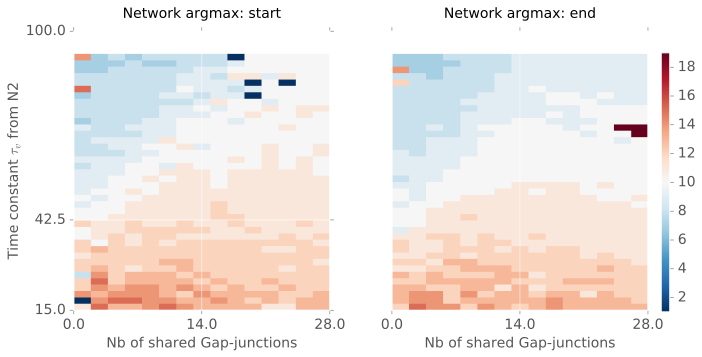

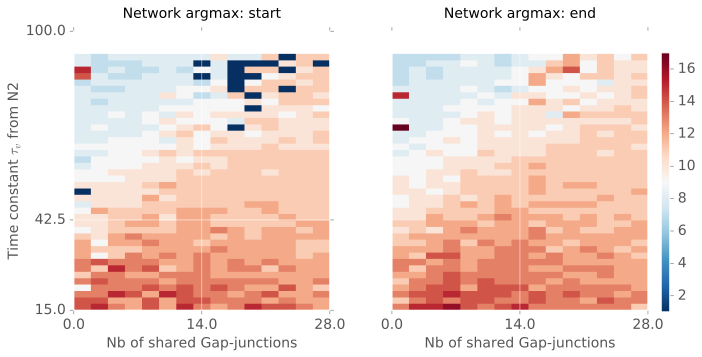

In [19]:
gr.plotCoherenceEvolution(df, kind='argmax', LTD=True)
gr.plotCoherenceEvolution(df, kind='argmax', LTD=False)

(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)
(1200,)
(80, 15)


0

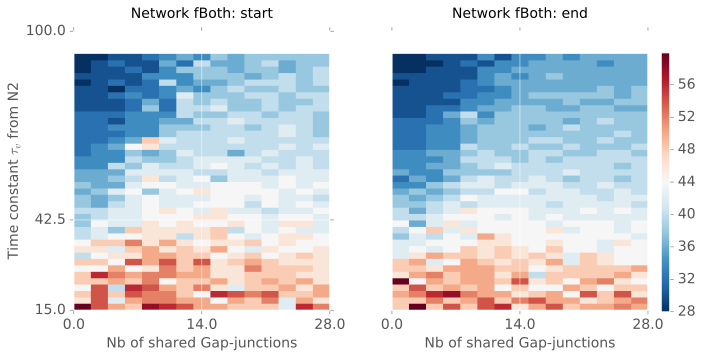

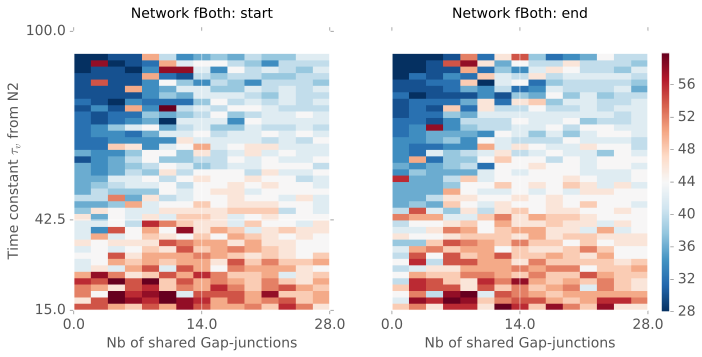

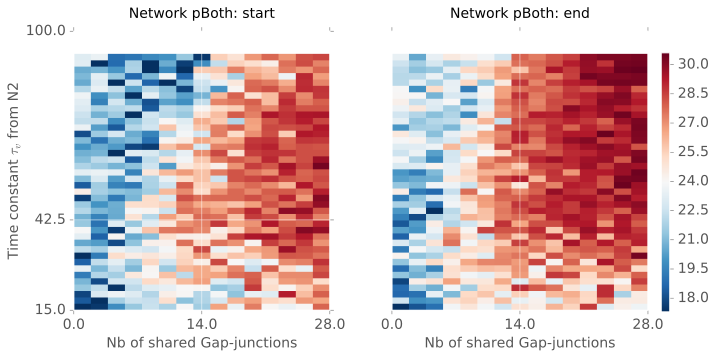

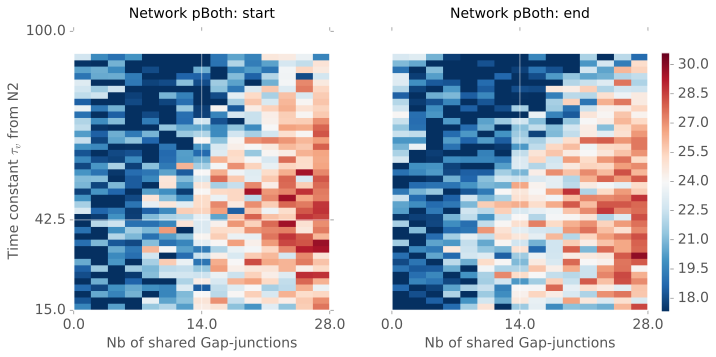

In [20]:
gr = GRAPH(cortex)
gr.plotCoherenceEvolution(df, kind='fBoth', LTD=True, sWII = sWII, 
                         vmax=dfplast['fBothEnd'].max(), vmin=dfplast['fBothEnd'].min())
gr.plotCoherenceEvolution(df, kind='fBoth', LTD=False, sWII = sWII,
                          vmax=dfplast['fBothEnd'].max(), vmin=dfplast['fBothEnd'].min())

gr.plotCoherenceEvolution(df, kind='pBoth', LTD=True, sWII = sWII,
                         vmax=dfplast['pBothEnd'].max(), vmin=dfplast['pBothEnd'].min())
gr.plotCoherenceEvolution(df, kind='pBoth', LTD=False, sWII = sWII, 
                          vmax=dfplast['pBothEnd'].max(), vmin=dfplast['pBothEnd'].min())

(2400,)
(160, 15)
(2400,)
(160, 15)


/Users/GP1514/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


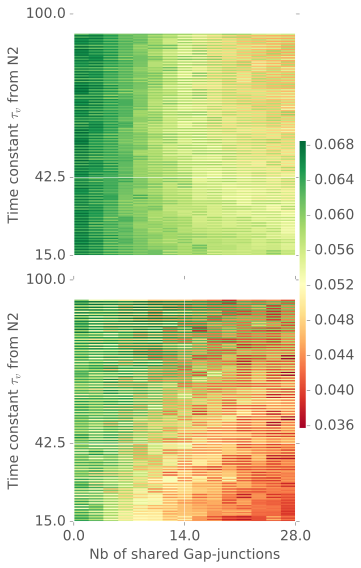

/Users/GP1514/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


0

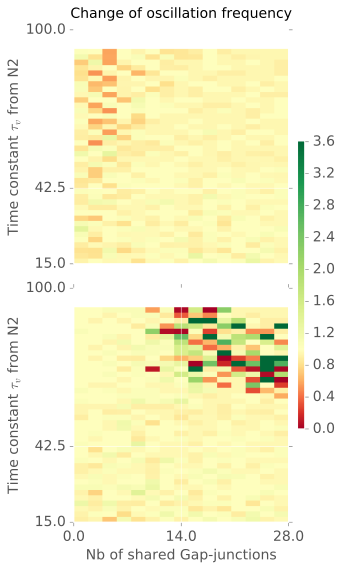

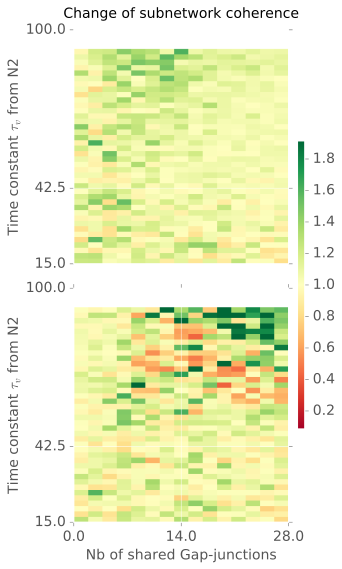

In [22]:
gr = GRAPH(cortex)
gr.plotChange2(df, 'f', 'N1', both=True, title='Change of oscillation frequency', sWII=sWII, LTD=True)
gr.plotChange2(df, 'p', 'N1', both=True, title='Change of subnetwork coherence', sWII=sWII)
# plotChange('f1', 'N1')
# plotChange('f1', 'N1', both=True)
# plotChange('f2', 'N2', both=True)
# plotChange('p1', 'N1', both=True)
# plotChange('p2', 'N2', both=True)

## CSD BEFORE AFTER

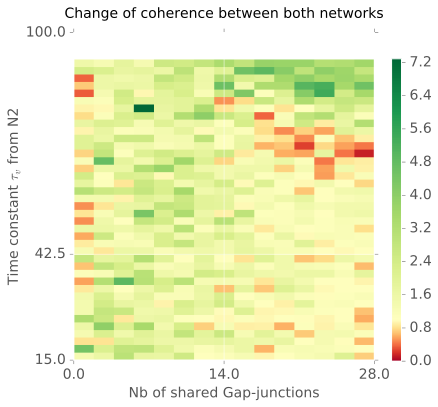

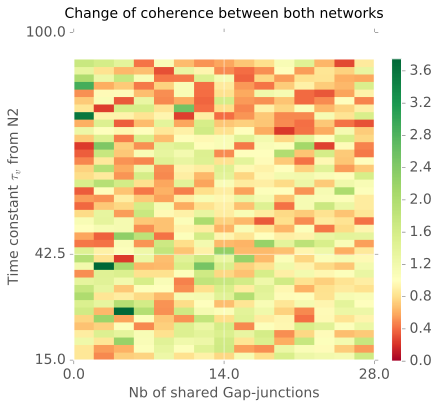

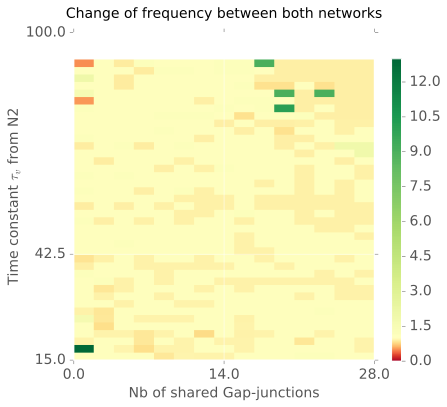

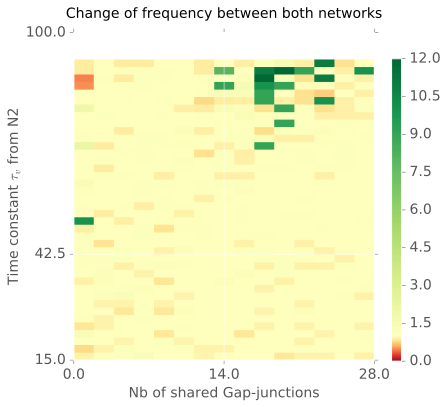

In [23]:
gr = GRAPH(cortex)
# power
gr.plotChange(df, 'max', title="Change of coherence between both networks", sWII=sWII, LTD=True)
gr.plotChange(df, 'max', title="Change of coherence between both networks", sWII=sWII, LTD=False)
# freq
gr.plotChange(df, 'argmax', title="Change of frequency between both networks", sWII=sWII, LTD=True)
gr.plotChange(df, 'argmax', title="Change of frequency between both networks", sWII=sWII, LTD=False)

## FOURIER (i1+i2) BEFORE AFTER

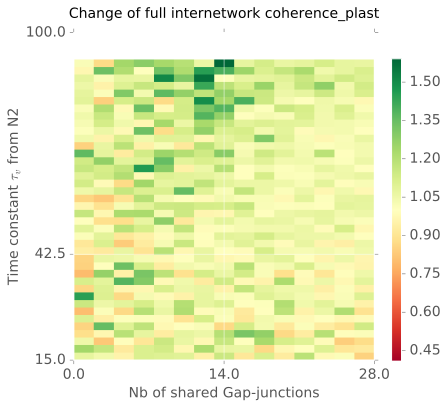

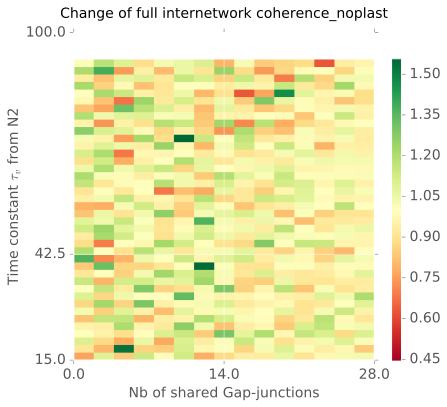

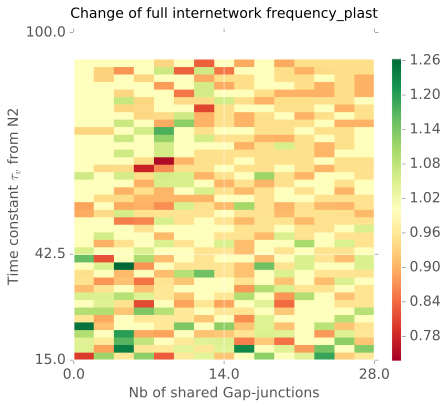

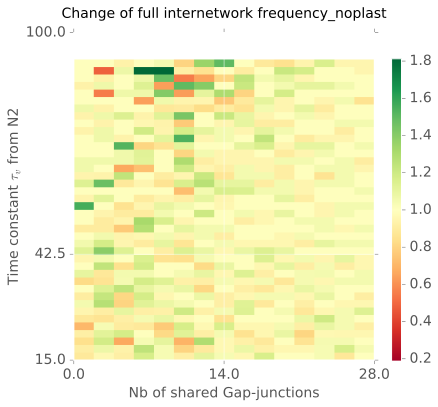

In [24]:
# power
gr.plotChange(df, 'pBoth', title="Change of full internetwork coherence_plast", LTD=True, sWII=sWII)
gr.plotChange(df, 'pBoth', title="Change of full internetwork coherence_noplast", LTD=False, sWII =sWII)
# freq
gr.plotChange(df, 'fBoth', title="Change of full internetwork frequency_plast", LTD=True, sWII = sWII)
gr.plotChange(df, 'fBoth', title="Change of full internetwork frequency_noplast", LTD=False, sWII = sWII)

## Plot difference between with and without plasticity

/Users/GP1514/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


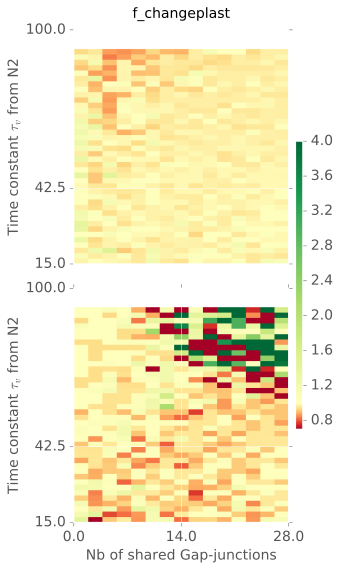

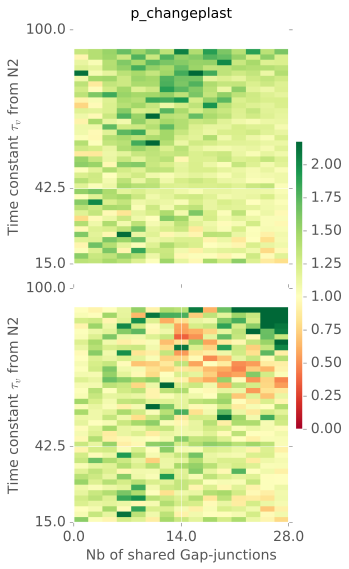

In [25]:
gr.plotChangePlast2(df, 'f', 'N1', both=True, title='f_changeplast', sWII=sWII, vmax=4, vmin=0.7)
plt.savefig(DIRECTORY+'f_changeplast_%d_%d.pdf'%(sWII,N))
plt.figure()
gr.plotChangePlast2(df, 'p', 'N1', both=True, title='p_changeplast', sWII=sWII)
plt.savefig(DIRECTORY+'p_changeplast_%d_%d.pdf'%(sWII,N))


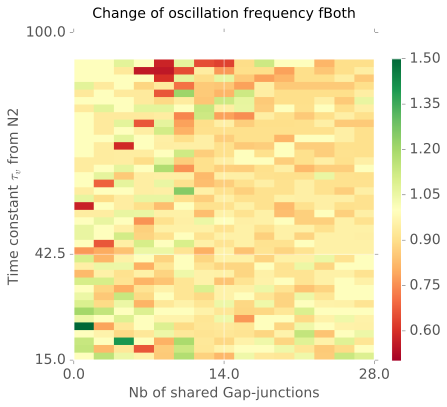

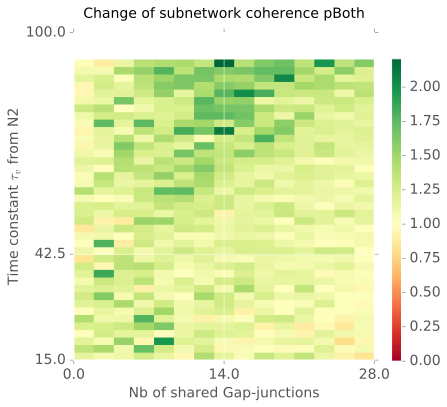

In [26]:
gr = GRAPH(cortex)
# gr.plotChangePlast(df, 'max', title='Change of oscillation frequency', sWII=10, vmax=1.3)
# gr.plotChangePlast(df, 'argmax', title='Change of subnetwork coherence', sWII=10)
gr.plotChangePlast(df, 'fBoth', title='Change of oscillation frequency fBoth', sWII=sWII)
# plt.savefig(DIRECTORY+'change_of_fBoth_plast_vs_noplast.pdf')
plt.figure()
gr.plotChangePlast(df, 'pBoth', title='Change of subnetwork coherence pBoth', sWII=sWII)
# plt.savefig(DIRECTORY+'change_of_pBoth_plast_vs_noplast.pdf')


In [27]:
# # c = cortex
# c.with_currents = True
# c.N = 300
# c.g = 10
# c.d1 = 10
# c.d2 = 1012
# c.d3 = 10
# c.T = 1020
# c.tauv = 15
# c.sG=20
# c.sWII=0
# c.dt=0.25
# # c.runSimulation(tauv=c.tauv)
# # c.readSimulation()
# # gr.plotWeights(tauv=c.tauv)

In [28]:
# t0 = t.time()

# c.runSimulation(tauv=c.tauv)
# print(t.time()-t0)

In [29]:
# c.readSimulation()
# plt.plot(c.voltage)

In [30]:
# c.dt = 0.25
# c.N = 400
# c.g = 10
# c.d1 = 10
# c.d2 = 30000
# c.d3 = 10
# c.initTime()
# c.sigma = 60
# c.WII = 1400 #2800
# c.S = 100
# c.model = "gp-izh-subnetworks"
# c.glob = 0

# # shared weights
# c.sG = 10
# c.sWII = 10

# c.FACT = 1
# c.r=0

# c.ratio = 15
# c.LTD  = 1e-0*4.7e-6 * c.FACT * c.N
# c.LTP = c.ratio * c.LTD

# c.tauv=15

# c.with_currents = True

# # for S in np.arange(50,400,50):
# #     Parallel(n_jobs=8)(delayed(cortex.runSimulation)(N,0, G, S, d1, d2, d3, before, after, sigma, \
# # WII, LTP, LTD) for G in np.linspace(1,9,"8))

# sWIIList = [0,10]
# sGList = [0,1,5,10,15,20,25]
# sGList = np.arange(0,25,4)
# LTDList = [1e-9*4.7e-6 * c.FACT * c.N, 1e-0*4.7e-6 * c.FACT * c.N]
# taulist = np.arange(11,95,4)
# c.LTD = LTDList[0]
# c.sG = sGList[0]
# c.LTP = c.ratio * c.LTD
# c.readSimulation()

In [31]:
# dfnoplast['fBothEnd'].var()

In [32]:
# c.d2 = 10000
# c.N = 50
# c.after = 1000
# c.dt=0.25
# c.LTD = LTDList[1]*10
# c.LTP = c.LTD * c.ratio
# c.T = c.d1+c.d2+c.d3
# c.runSimulation()

In [33]:
# c.readSimulation()
# c.gammaN1[-10:]

## PLOT DIAGRAM + PLAST COMPARISON FOR COHERENCE

In [34]:


#create new SVG figure
fig = sg.SVGFigure("20cm", "7cm")

# load matpotlib-generated figures
fig1 = sg.fromfile(FIG_DIR + str(todayStr) + '/power_clusterTrue_%d_%d.svg'%(sWII,N))
fig2 = sg.fromfile(FIG_DIR + str(todayStr) + '/power_clusterFalse_%d_%d.svg'%(sWII,N))
fig3 = sg.fromfile(FIG_DIR + str(todayStr) + '/p_changeplast2_%d_%d.svg'%(sWII,N))

# get the plot objects
scale = 0.45
plot1 = fig1.getroot()
plot1.moveto(0,10,scale= scale)
plot2 = fig2.getroot()
plot2.moveto(280, 10, scale = scale)
plot3 = fig3.getroot()
plot3.moveto(560, 20, scale = scale*0.95)

# add text labels
txt1 = sg.TextElement(5,30, "A", size=12, weight="bold")
plast = sg.TextElement(85,10, "Plasticity", size=12, weight="normal")
noplast = sg.TextElement(360,10, "No plasticity", size=12, weight="normal")
txt2 = sg.TextElement(285,30, "B", size=12, weight="bold")
txt3 = sg.TextElement(560,30, "C", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3])
fig.append([txt1, txt2, txt3, plast, noplast])

# save generated SVG files
fig.save(DIRECTORY + "powercluster_%d_%d.svg"%(sWII,N))
svg2pdf('powercluster_%d_%d'%(sWII,N),DIRECTORY)



## PLOT DIAGRAM + PLAST COMPARISON FOR FREQUENCY

In [35]:
#create new SVG figure
fig = sg.SVGFigure("20cm", "10cm")

# load matpotlib-generated figures
fig1 = sg.fromfile(FIG_DIR + str(todayStr) + '/frequency_clusterTrue_%d_%d.svg'%(sWII,N))
fig2 = sg.fromfile(FIG_DIR + str(todayStr) + '/frequency_clusterFalse_%d_%d.svg'%(sWII,N))
fig3 = sg.fromfile(FIG_DIR + str(todayStr) + '/f_changeplast2_%d_%d.svg'%(sWII,N))

# get the plot objects
scale = 0.45
plot1 = fig1.getroot()
plot1.moveto(0,10,scale= scale)
plot2 = fig2.getroot()
plot2.moveto(280, 10, scale = scale)
plot3 = fig3.getroot()
plot3.moveto(560, 20, scale = scale*0.95)

# add text labels
txt1 = sg.TextElement(5,30, "A", size=12, weight="bold")
plast = sg.TextElement(85,10, "Plasticity", size=12, weight="normal")
noplast = sg.TextElement(360,10, "No plasticity", size=12, weight="normal")
txt2 = sg.TextElement(285,30, "B", size=12, weight="bold")
txt3 = sg.TextElement(560,30, "C", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3])
fig.append([txt1, txt2, txt3, plast, noplast])

# save generated SVG files
fig.save(DIRECTORY + 'freqcluster_%d_%d.svg'%(sWII,N))
svg2pdf('freqcluster_%d_%d'%(sWII,N),DIRECTORY)

## PLOT DIAGRAM + PLAST COMPARISON FOR FREQUENCY : INTERNETWORK

In [36]:
#create new SVG figure
fig = sg.SVGFigure("20cm", "15cm")

# load matpotlib-generated figures
fig1 = sg.fromfile(FIG_DIR + str(todayStr) + '/fBoth_cluster_plastFalse_%d_%d.svg'%(sWII,N))
fig2 = sg.fromfile(FIG_DIR + str(todayStr) + '/fBoth_cluster_plastTrue_%d_%d.svg'%(sWII,N))
fig3 = sg.fromfile(FIG_DIR + str(todayStr) + '/fBothChange_of_full_internetwork_frequency_noplast_%d_%d.svg'%(sWII,N))
fig4 = sg.fromfile(FIG_DIR + str(todayStr) + '/fBothChange_of_full_internetwork_frequency_plast_%d_%d.svg'%(sWII,N))
fig5 = sg.fromfile(FIG_DIR + str(todayStr) + '/fboth_changePLAST_cluster_%d_%d.svg'%(sWII,N))


# get the plot objects
scale = 0.45
plot1 = fig1.getroot()
plot1.moveto(0,0,scale= scale)
plot2 = fig2.getroot()
plot2.moveto(0, 180, scale = scale)
plot3 = fig3.getroot()
plot3.moveto(350, 0, scale = scale*0.85)
plot4 = fig4.getroot()
plot4.moveto(350, 180, scale = scale*0.85)
plot5 = fig5.getroot()
plot5.moveto(170, 340, scale = scale*0.85)

# add text labels
# txt1 = sg.TextElement(5,20, "A", size=12, weight="bold")
# txt2 = sg.TextElement(285,20, "B", size=12, weight="bold")
# txt3 = sg.TextElement(560,20, "C", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4, plot5])
# fig.append([txt1, txt2, txt3])

# save generated SVG files
fig.save(DIRECTORY + 'freq_change_%d_%d.svg'%(sWII,N))
svg2pdf('freq_change_%d_%d'%(sWII, N),DIRECTORY)

## PLOT DIAGRAM + PLAST COMPARISON FOR POWER : INTERNETWORK

In [37]:
#create new SVG figure
fig = sg.SVGFigure("14cm", "14cm")

# load matpotlib-generated figures
fig1 = sg.fromfile(FIG_DIR + str(todayStr) + '/pBoth_cluster_plastFalse_%d_%d.svg'%(sWII,N))
fig2 = sg.fromfile(FIG_DIR + str(todayStr) + '/pBoth_cluster_plastTrue_%d_%d.svg'%(sWII,N))
fig3 = sg.fromfile(FIG_DIR + str(todayStr) + '/pBothChange_of_full_internetwork_coherence_noplast_%d_%d.svg'%(sWII,N))
fig4 = sg.fromfile(FIG_DIR + str(todayStr) + '/pBothChange_of_full_internetwork_coherence_plast_%d_%d.svg'%(sWII,N))
fig5 = sg.fromfile(FIG_DIR + str(todayStr) + '/pboth_changePLAST_cluster_%d_%d.svg'%(sWII,N))


# get the plot objects
scale = 0.45
plot1 = fig1.getroot()
plot1.moveto(0,0,scale= scale)
plot2 = fig2.getroot()
plot2.moveto(0, 180, scale = scale)
plot3 = fig3.getroot()
plot3.moveto(350, 0, scale = scale*0.85)
plot4 = fig4.getroot()
plot4.moveto(350, 180, scale = scale*0.85)
plot5 = fig5.getroot()
plot5.moveto(170, 340, scale = scale*0.85)

# add text labels
# txt1 = sg.TextElement(5,20, "A", size=12, weight="bold")
# txt2 = sg.TextElement(285,20, "B", size=12, weight="bold")
# txt3 = sg.TextElement(560,20, "C", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4, plot5])
# fig.append([txt1, txt2, txt3])

# save generated SVG files
fig.save(DIRECTORY + 'power_change_%d_%d.svg'%(sWII,N))
svg2pdf('power_change_%d_%d'%(sWII,N),DIRECTORY)